In [11]:
import sys
sys.path
sys.path.append('/Users/tylerac/Documents/VS_Code_Projects/ReCirq Stuff/ReCirq')

In [12]:
sys.path

['/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/Users/tylerac/Documents/VS_Code_Projects/ReCirq Stuff/.venv/lib/python3.11/site-packages',
 '/Users/tylerac/Documents/VS_Code_Projects/ReCirq Stuff',
 '/Users/tylerac/Documents/VS_Code_Projects/ReCirq Stuff/',
 '/Users/tylerac/Documents/VS_Code_Projects/ReCirq Stuff/ReCirq']

In [14]:
import cirq
from matplotlib.colors import LinearSegmentedColormap#, ListedColormap
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
import numpy as np
from matplotlib import colormaps
import qsimcirq
from scipy.optimize import minimize_scalar
import sympy

import recirq.lattice_gauge.lattice_gauge_experiment as lgt
from recirq.lattice_gauge.lattice_gauge_grid import LGTGrid
import recirq.toric_code.toric_code_plotter as tc_plot
import recirq.toric_code.toric_code_plaquettes as tc_plaq
import recirq.toric_code.toric_code_rectangle as tcr

In [15]:
#Notebook Parameters

reps = 1_000

number_of_gauge_qubits = 17

plt.rcParams['figure.dpi'] = 72
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.markeredgewidth'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True

WALA_INITIAL = np.array([0, 0.35746251, 0.14352941, 1])
TORIC_INITIAL = 'steelblue'
POLARIZED_INITIAL = "#fbbc04"
BREAKING_BOTTOM = '#67cd85ff'
BREAKING_TOP = '#e6a304ff'
BREAKING_VAC = 'k'

cmap1 = LinearSegmentedColormap.from_list("1", ['darkred', 'salmon'],gamma=1.0)
cmap2 = LinearSegmentedColormap.from_list("2", ['salmon','lightgrey'],gamma=1.0)
cmap3 = LinearSegmentedColormap.from_list("3", ['lightgrey','lightsteelblue'],gamma=1.0)
cmap4 = LinearSegmentedColormap.from_list("4", ['lightsteelblue','steelblue'],gamma=1.0)
color_list = [cmap1(i) for i in np.arange(0,1,1/375)]+ [cmap2(i) for i in np.arange(0,1,1/250)]  + [cmap3(i) for i in np.arange(0,1,1/30)] + [cmap4(i) for i in np.arange(0,1,1/95)]
charge_cmap = LinearSegmentedColormap.from_list("Charge", color_list,gamma=1)
charge_cmap_r = LinearSegmentedColormap.from_list("Charge_r", color_list[::-1],gamma=1)

he_list = [0,0.3,0.6,0.8,2.0]
blues_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "Blues", [(0.0,'k'),(0.5,'steelblue'), (1.0,(0.9*0.6901960784313725, 0.9*0.7686274509803922, 1.0*0.8705882352941177, 1.0))]
)
blues_cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list(
    "Blues_r", [(1.0,'k'),(0.5,'steelblue'), (0.0,(0.9*0.6901960784313725, 0.9*0.7686274509803922, 1.0*0.8705882352941177, 1.0))][::-1]
)
blues_color_list = [blues_cmap(i) for i in np.arange(1,-0.01,-1/(max(len(he_list)-1,1)))]

colors_greens1 = ['white', '#009468ff']
colors_greens2 = ["#bdc1c6",'#009468ff']
colors_greens3 = ['#009468ff','black']
cmap_greens1 = LinearSegmentedColormap.from_list("1", colors_greens1,gamma=3.5)
cmap_greens2 = LinearSegmentedColormap.from_list("mycmap", colors_greens3,gamma=0.8)
color_list = ([cmap_greens1(i) for i in np.arange(0,1,1/10240)] + [cmap_greens2(i) for i in np.arange(0,1,1/12500)])
cmap_green = LinearSegmentedColormap.from_list("mycmap", color_list,gamma=1)
cmap_green_r = LinearSegmentedColormap.from_list("mycmap", color_list[::-1],gamma=1)

colors = ['darkred', 'salmon']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors,gamma=4.0)
colors = ['salmon','lightgrey']
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors,gamma=1.0)
colors = ['lightgrey','lightsteelblue']
cmap3 = LinearSegmentedColormap.from_list("mycmap", colors,gamma=1.0)
colors = ['lightsteelblue','steelblue']
cmap4 = LinearSegmentedColormap.from_list("mycmap", colors,gamma=0.5)
color_list = [cmap1(i) for i in np.arange(0,1,1/1500)]+ [cmap2(i) for i in np.arange(0,1,1/300)]  + [cmap3(i) for i in np.arange(0,1,1/300)] + [cmap4(i) for i in np.arange(0,1,1/1500)]
diff_cmap = LinearSegmentedColormap.from_list("mycmap", color_list,gamma=1)
diff_cmap_r = LinearSegmentedColormap.from_list("mycmap", color_list[::-1],gamma=1)



In [16]:
#Notebook Functions

def mean_field_energy(theta, Lx=5, Ly=5, Je=1., Jm=1., he=0.0):
    energy = - Je * Lx * Ly\
             - Jm * (Lx-1) * (Ly-1) * np.sin(theta)\
             - he * (2 * (Lx-1) + 2 * (Ly-1)) * np.cos(theta)\
             - he * (2 * Lx * Ly - 3 * Lx - 3 * Ly + 4) * np.cos(theta)**2
    return energy

def bitstring_to_expectation_value(
        bitstrings:np.ndarray
)->np.ndarray:
    return -2 * bitstrings + 1

def energy_from_measurements(
        hamiltonian_coefs:dict,
        z_basis_results:np.ndarray,
        x_basis_results:np.ndarray
) -> float:
    return (-hamiltonian_coefs['Je'] * np.sum(np.mean(bitstring_to_expectation_value(lgt.plaquette_bitstrings(z_basis_results,grid)),axis=0))
            -hamiltonian_coefs['Jm'] * np.sum(np.mean(bitstring_to_expectation_value(lgt.x_plaquette_bitstrings(x_basis_results,grid)),axis=0))
            -hamiltonian_coefs['he'] * np.sum(np.mean(bitstring_to_expectation_value(z_basis_results),axis=0))
            -hamiltonian_coefs['lambda'] * np.sum(np.mean(bitstring_to_expectation_value(x_basis_results),axis=0))
            )

### Motivation and background

This ReCirq tutorial is based on experiments done on Google's quantum processor, the results of which can be found on [arXiv](https://arxiv.org/abs/2409.17142).

Gauge theories are a fundamental way to describe nature. From the quantum description of electromagnetic phenomena (dubbed quantum electrodynamics) to the theories that explain the fundamental particles explored at the Large Hadron Collider in Switzerland, gauge theories are ubiquitous throughout physics. While studies of gauge theories began analytically (pen and paper), soon the continuous theories were discretized and physicists began studying "lattice gauge theories," which are advantageous for numerical simulations. However, certain lattice gauge theories have proven intractable for classical computers because of the exponential cost to simulate larger systems. This provides a unique opportunity for today's emerging quantum computers to simulate results beyond the capabilities of classical processors. Along those lines, researchers have used superconducting qubits, arrays of neutral atoms, and trapped ions to simulate one dimensional lattice gauge theories. These experiments have shown the ability for quantum processors to capture the expected behavior in small, spatially limited systems. In our work, we extend the state-of-the-art by pushing the quantum simulation of gauge theories to two spatial dimensions. Specifically, we study the dynamics of a 2D grid of superconducting qubits under a Trotterized time evolution described by a $\mathbb{Z}_2$ lattice gauge theory with Hamiltonian:

$$\mathcal{H}=-J_E\sum_{v}\hspace{-0.6mm}A_v -J_M\sum_{p} \hspace{-0.6mm}B_p-h_E\sum_{\text{links}}\hspace{-0.6mm}Z_l-\lambda\sum_{\text{links}}\hspace{-0.6mm}X_l$$

$$A_v=\prod_{i \in v} Z_i$$

$$B_p=\prod_{i \in p} X_i.$$

As depicted in the schematic below, the $A_v$ operators correspond to electric "charges" that can exist on a vertex $v$. The $B_p$ operators correspond to magnetic excitations, that are defined on the dual lattice of plaquettes, indexed by $p$. The $h_E$ term represents the energy associated with the "electric field", while $\lambda$ controls the coupling between electric charges.

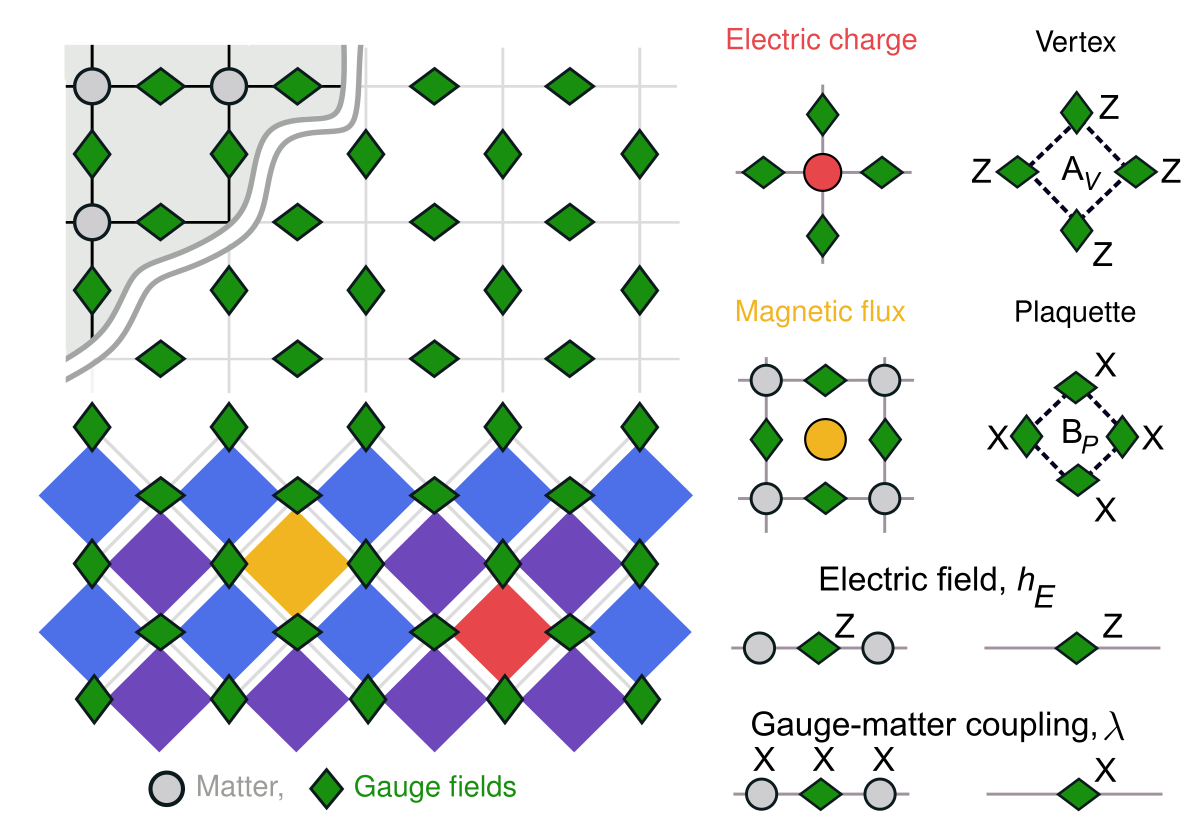

After first preparing a low energy state, we excite the system by pair-creating charges connected by a string of gauge flux. Based on the value of $h_E$, the theory will be in a confined or a deconfined regime. We see this transition by tracking the Hamiltonian evolution of charges and the average separation of an initialized pair. Then we turn to exploring the dynamics of a string of gauge flux connecting two charges that are "pinned" to the boundary of the grid. The string displays behavior that shows the transition from a deconfined, to a weakly and finally to a strongly confined regime as $h_E$ is increased. Finally, by initiating a string across the grid, but then measuring the pair-creation of additional charges, we observe evidence of string breaking in the confined regime as the coupling parameter, $\lambda$, is tuned.

### Prepare a low energy initial state: WALA

We start by preparing a low-energy state, on top of which we will pair-create charges. Our approach is to use a "Weight Adjustable Loop Ansatz" (WALA), which is equivalent to the mean-field ground state of the dual Ising model when $\lambda = 0$. The ansatz only has one tunable parameter, $\theta$. Since an expression for the mean-field Ising model is known exactly, the variational parameters for the WALA initial state can be efficiently classically calculated for any system size. In the limit of $h_E \rightarrow 0$, the WALA reduces to the ground state of the toric code, previously explored in [ReCirq](https://quantumai.google/cirq/experiments/toric_code/toric_code_ground_state). As shown below, we choose a system size that has a 4x3 grid of charge sites, which corresponds to 17 gauge qubits.

Note that in the experiment on quantum hardware, we use an additional 18 ancilla qubits to facilitate the Trotterization on the square grid of qubits with nearest-neighbor connectivity. However, to perform a Cirq simulation of these circuits, I will use a modified Trotter evolution that is not limited by the device connectivity and only uses the minimal number of physical qubits, at the cost of more gate layers.

We start by initializing a `grid` object that serves to keep track of the qubits.

In [17]:
Lx = 4
Ly = 3

grid = LGTGrid(origin_qubit = cirq.GridQubit(0,0),orientation_vector = (1,1), rows = Lx-1, cols = Ly-1, flip_rowcol = False)

This is visualized below where the grey diamonds correspond to the gauge qubits and the possible sites for charge excitations are shown in blue:

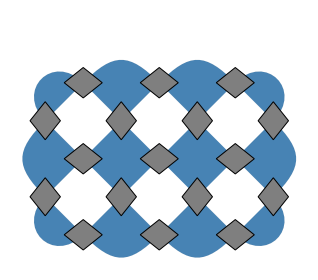

In [18]:
code = tcr.ToricCodeRectangle(origin_qubit=cirq.GridQubit(0,0), row_vector=(1,1), rows=grid.cols, cols=grid.rows)

fig, ax = plt.subplots()

tc_plot.ToricCodePlotter(z_cmap = charge_cmap, x_cmap = matplotlib.colormaps['binary']).plot_expectation_values(tc_plaq.ToricCodePlaquettes(
                code,
                x_plaquettes = np.zeros((code.rows,code.cols))-1,
                z_plaquettes = np.zeros((code.rows+1,code.cols+1))+1
            ),patch_kwargs={'linewidth':0.025},ax = ax)

lgt.plot_qubit_polarization_values(
            ax = ax,
            grid = LGTGrid(origin_qubit = cirq.GridQubit(0,0),orientation_vector = (1,1), rows = grid.cols, cols = grid.rows, flip_rowcol = False),
            qubit_polarization_data=np.zeros(17),
            ancilla_states_data=np.zeros(18),
            plot_physical_qubits=True,
            plot_ancillas = False,
            qubit_colormap=matplotlib.colormaps['binary']
        )

plt.show()

Next, we populate a dictionary with the optimal WALA angle, $\theta$, for each $h_E$:

In [19]:
he_list = np.around(np.linspace(0,3,31),2)

angles = {}
for he in he_list:
    fun = lambda theta: mean_field_energy(theta, Lx=Lx+1, Ly=Ly+1, he=he)
    res = minimize_scalar(fun, bracket=(0, np.pi/2))
    angles[np.around(he,2)]= res.x

and then use those angles to define the circuits to create the WALA state:

In [20]:
cirq.Circuit.from_moments(*lgt.variational_ground_state_minimal_qubits(grid,sympy.Symbol('theta')))

┌──┐           ┌──┐           ┌──┐
(-1, 0): ───Ry(theta)─────────@──────────────@───────────────────────
                              │              │
(-1, 2): ───Ry(theta)────────@┼─────────────@┼───────────────────────
                             ││             ││
(0, -1): ───────────────H────┼@────H────────┼┼─────────────@─────────
                             │              ││             │
(0, 1): ────────────────H────@─────H───H────┼@────H────────┼─────────
                                            │              │
(0, 3): ───────────────────────────────H────@─────H────────┼@────────
                                                           ││
(1, 0): ────Ry(theta)────────@──────────────@─────────H────@┼────H───
                             │              │               │
(1, 2): ────Ry(theta)────────┼@─────────────┼@────────H─────@────H───
                             ││             ││
(2, -1): ───────────────H────@┼────H────────┼┼─────────────@─────────
                              │             ││             │
(2, 1): ────────────────H─────@────H───H────@┼────H────────┼─────────
                                             │             │
(2, 3): ───────────────────────────────H─────@────H────────┼@────────
                                                           ││
(3, 0): ────Ry(theta)────────@──────────────@─────────H────@┼────H───
                             │              │               │
(3, 2): ────Ry(theta)────────┼@─────────────┼@────────H─────@────H───
                             ││             ││
(4, -1): ───────────────H────@┼────H────────┼┼─────────────@─────────
                              │             ││             │
(4, 1): ────────────────H─────@────H───H────@┼────H────────┼─────────
                                             │             │
(4, 3): ───────────────────────────────H─────@────H────────┼@────────
                                                           ││
(5, 0): ──────────────────────────────────────────────H────@┼────H───
                                                            │
(5, 2): ──────────────────────────────────────────────H─────@────H───
                            └──┘           └──┘           └──┘

Adding measurements in the Z and X bases, we populate lists of circuits for many values of $h_E$ to simulate the energy of the WALA state and compare this to the energy of the trivial product state where all qubits are in the $\ket{0}$ state.

In [21]:
wala_circuits_z=[]
wala_circuits_x=[]

for he in he_list:
    wala_circuits_z.append(cirq.Circuit.from_moments(*lgt.variational_ground_state_minimal_qubits(grid,angles[he]))+cirq.measure(*sorted(grid.physical_qubits), key="measure_all"))
    wala_circuits_x.append(cirq.Circuit.from_moments(*lgt.variational_ground_state_minimal_qubits(grid,angles[he]))+cirq.H.on_each(grid.physical_qubits)+cirq.measure(*sorted(grid.physical_qubits), key="measure_all"))

polarized_circuit_z = cirq.Circuit.from_moments(cirq.Moment(cirq.measure(*sorted(grid.physical_qubits), key="measure_all")))
polarized_circuit_x = cirq.Circuit.from_moments(cirq.Moment(cirq.H.on_each(grid.physical_qubits)),cirq.Moment(cirq.measure(*sorted(grid.physical_qubits), key="measure_all")))

Let's simulate these circuits using qsim. Since we're simulating a few 10s of circuits with 17 qubits, this should take less that 1 second.

In [22]:
simulator = qsimcirq.QSimSimulator()

results_wala_z = simulator.run_batch(wala_circuits_z,repetitions=reps)
results_wala_x = simulator.run_batch(wala_circuits_x,repetitions=reps)

results_polarized_z = simulator.run(polarized_circuit_z,repetitions = reps)
results_polarized_x = simulator.run(polarized_circuit_x,repetitions = reps)

results_wala_combined = {}
for idx,he in enumerate(he_list):
    results_wala_combined[('basis_z',f'he_{np.around(he,2)}')] = results_wala_z[idx][0]
    results_wala_combined[('basis_x',f'he_{np.around(he,2)}')] = results_wala_x[idx][0]

results_polarized = {}
results_polarized['basis_z'] = results_polarized_z
results_polarized['basis_x'] = results_polarized_x

Now, we can take these measurements, which correspond to the initial states with different values of $h_E$, and calculate the energy based on the Hamiltonian, $\mathcal{H}$:

In [23]:
wala_energies_dict = {}
toric_code_energies_dict = {}
polarized_energies_dict = {}
for idx, he in enumerate(he_list):
    energy = energy_from_measurements(
        hamiltonian_coefs = {'Je':1,'Jm':1,'he':he,'lambda':0.25},
        z_basis_results = results_wala_combined[('basis_z',f'he_{np.around(he,2)}')].measurements['measure_all'],
        x_basis_results = results_wala_combined[('basis_x',f'he_{np.around(he,2)}')].measurements['measure_all']
    )

    wala_energies_dict[he] = energy

    energy = energy_from_measurements(
        hamiltonian_coefs = {'Je':1,'Jm':1,'he':he,'lambda':0.25},
        z_basis_results = results_wala_combined[('basis_z',f'he_{0.0}')].measurements['measure_all'],
        x_basis_results = results_wala_combined[('basis_x',f'he_{0.0}')].measurements['measure_all']
    )

    toric_code_energies_dict[he] = energy

    energy = energy_from_measurements(
        hamiltonian_coefs = {'Je':1,'Jm':1,'he':he,'lambda':0.25},
        z_basis_results = results_polarized['basis_z'].measurements['measure_all'],
        x_basis_results = results_polarized['basis_x'].measurements['measure_all']
    )

    polarized_energies_dict[he] = energy

Plot the energies!

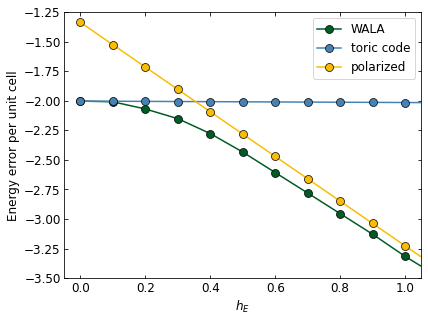

In [24]:
fig,ax = plt.subplots()

ax.plot(wala_energies_dict.keys(),np.array(list(wala_energies_dict.values()))/((number_of_gauge_qubits+1)/2), marker = "o", color = WALA_INITIAL, label='WALA')
ax.plot(toric_code_energies_dict.keys(),np.array(list(toric_code_energies_dict.values()))/((number_of_gauge_qubits+1)/2), marker = "o", color = TORIC_INITIAL, label='toric code')
ax.plot(polarized_energies_dict.keys(),np.array(list(polarized_energies_dict.values()))/((number_of_gauge_qubits+1)/2),marker='o', color= POLARIZED_INITIAL, label = 'polarized')

ax.set_xlabel("$h_E$")
ax.set_ylabel("Energy error per unit cell")
ax.set_xbound(-0.05,1.05)
ax.set_ybound(-3.5,-1.25)
ax.legend()

plt.show()

We can see that the WALA state yields an energy as low or lower than the two limiting cases of the toric code and polarized states across the entire range of $h_E$. The next step is to pair-create charge excitations on top of the WALA state with X gates and measure the Trotterized dynamics.

### Dynamics of Charges

By applying a single X gate on qubit `cirq.GridQubit(2,1)`, we excite two charges next to each other in the center of the grid. By then simulating their Hamiltonian evolution, the dynamics reveal a fingerprint of the confinement.

We choose $h_E$ values between 0 (fully deconfined) and 2.0 (strongly confined) to simulate the dynamics. $J_E = J_M = 1$ and $\lambda = 0.25$ are held constant. For the Trotterized simulation, we find that at time step of $dt=0.3$ does not accumulate significant trotter error over the simulated 10 trotter steps.

A circuit with a single Trotter step now looks like:

In [25]:
excitation = cirq.Moment(cirq.X.on(cirq.GridQubit(2,1)))

cirq.Circuit.from_moments(
    *lgt.variational_ground_state_minimal_qubits(grid,sympy.Symbol('theta')),
    excitation,
    *lgt.trotter_step_minimal_qubits(grid,sympy.Symbol('dt'),sympy.Symbol('lambda'),sympy.Symbol('he')),
    cirq.Moment(cirq.measure(*sorted(grid.physical_qubits), key="measure_all"))
)


┌──┐           ┌──┐           ┌──┐               ┌──┐           ┌──┐                                               ┌──┐           ┌──┐
(-1, 0): ───Ry(theta)─────────@──────────────@───────────────────────────H────@─────H──────────────────────────────Rz(-2*dt)──────────────────────────────H────@─────H───H───@───H───────@───────────────────────────────────────────────@───────H───@───H───H───────────────H───@───H───H───@───H───Rz(-2*dt)───H───@───H───H───@───H───────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(-2*dt*he)───Rx(-2*dt*lambda)───M('measure_all')───
                              │              │                                │                                                                                │             │           │                                               │           │                           │           │                       │           │                                                                                                                                             │
(-1, 2): ───Ry(theta)────────@┼─────────────@┼───────────────────────────H────┼@────H──────────────────────────────Rz(-2*dt)──────────────────────────────H────┼@────H───────┼───────H───@───H───────────────Rz(-2*dt)───────────────H───@───H───────┼───────H───────────────────┼───────────┼───────────────────────┼───────────┼───────────────────────────────H───@───H───H───@───H───Rz(-2*dt)───H───@───H───H───@───H───────────────H───Rz(-2*dt*he)───Rx(-2*dt*lambda)───M──────────────────
                             ││             ││                                ││                                                                               ││            │                                                                       │                           │           │                       │           │                                   │           │                       │           │                                                         │
(0, -1): ───────────────H────┼@────H────────┼┼─────────────@──────────────────@┼────────H────@─────H───────────────Rz(-2*dt)───────────────H────@─────H────────@┼────────────┼───────────────────────────────────────────────────────────────────────┼───────H───H───@───H───────@───────────┼───────────────────────┼───────────@───────H───@───H───────────────────┼───────────┼───────────────────────┼───────────┼───────────────────H───Rz(-2*dt*he)───Rx(-2*dt*lambda)───M──────────────────
                             │              ││             │                   │             │                                                  │               │            │                                                                       │               │                       │                       │                       │                       │           │                       │           │                                                         │
(0, 1): ────────────────H────@─────H───H────┼@────H────────┼───────────────────┼─────────────┼──────────────────────────────────────────────────┼───────────────┼────────────@───────H───@───H───H───@───H───Rz(-2*dt)───H───@───H───H───@───H───────@───────H───────┼───────────────────────@───────────────────────@───────────────────────┼───────H───@───H───────@───────────┼───────────────────────┼───────────@───────H───@───H───H───Rz(-2*dt*he)───Rx(-2*dt*lambda)───M──────────────────
                                            │              │                   │             │                                                  │               │                        │           │                       │           │                           │                                                                       │           │                       │                       │                       │                                             │
(0, 3): ───────────────────────────────H────@─────H────────┼@────────────

Let's populate a list of circuits to simulate:

In [26]:
he_list = [0,0.3,0.6,0.8,2.0]
dt = 0.3
coupling = 0.25
trotter_steps = np.arange(10)

excitation = cirq.Moment(cirq.X.on(cirq.GridQubit(2,1)))

time_evolution_circuits = []

for he in he_list:
    for step in trotter_steps:
        time_evolution_circuits.append(cirq.Circuit.from_moments(
            *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
            excitation,
            *lgt.trotter_step_minimal_qubits(grid,dt,coupling,he)*step,
            cirq.Moment(cirq.measure(*sorted(grid.physical_qubits), key="measure_all"))
        ))

and run the simulations. Now that we're simulating deeper circuits for many Trotter steps, this may take a few seconds.

In [27]:
results_charge_dynamics = simulator.run_batch(time_evolution_circuits,repetitions=reps)

Now we will calculate the charge operator for each vertex, $v$. Then, by post-selecting on bitstrings that only have two charge excitations ($A_v = -1$ on two vertices and $+1$ for all others), we calculate the average distances between charges for each set of parameter values and number of trotter steps.

In [28]:
counter = 0

trotter_steps = np.arange(10)

occupations = {}
separations = {}
separations_sdom = {}

for he in he_list:
    separations[he] = []
    separations_sdom[he] = []
    for step in trotter_steps:
        occupations[(he,step)] = []
        res = results_charge_dynamics[counter][0].measurements['measure_all']
        charge_occupations = lgt.plaquette_bitstrings(res,grid)
        charge_excitation_number = np.sum(charge_occupations,axis = 1)
        post_selected_charge_occupations = charge_occupations[np.nonzero(charge_excitation_number==2)[0],:]
        charge_separation = lgt.excitation_sep_plaquette_input(
            post_selected_charge_occupations,
            grid.rows+1,
            grid.cols+1
        )
        
        occupations[(he,step)] = np.mean(charge_occupations, axis = 0)
        separations[he].append(np.mean(charge_separation))
        separations_sdom[he].append(np.nanstd(charge_separation)/np.sqrt(len(charge_separation)))

        counter += 1

To start to explore this data, we will plot heatmaps of $\langle A_v \rangle$ for each charge site for the deconfined ($h_E = 0$) and the confined ($h_E = 2.0$) cases for times $t \in \{0, 1.5,2.7\}$. Notice that the charges tend to separate much faster in the deconfined regime.

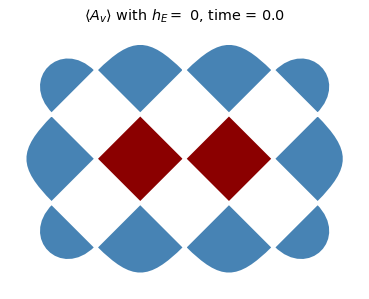

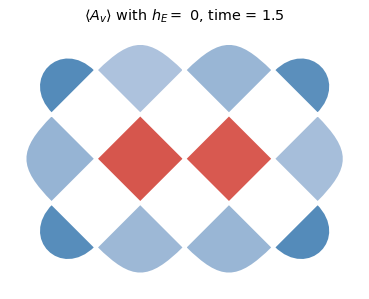

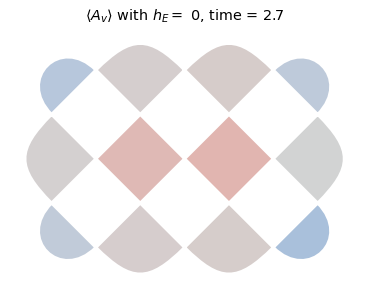

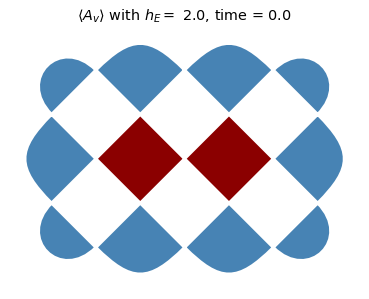

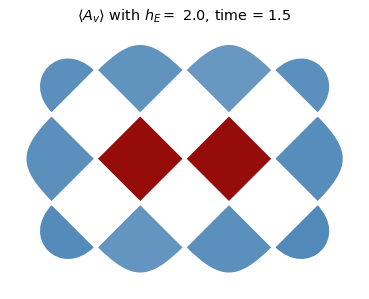

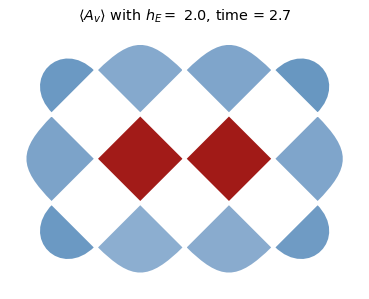

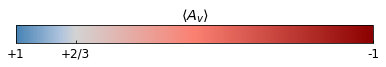

In [29]:
for he in [0,2.0]:
        for step in [0,5,9]:
            tc_plot.ToricCodePlotter(z_cmap = charge_cmap, x_cmap = matplotlib.colormaps['binary']).plot_expectation_values(tc_plaq.ToricCodePlaquettes(
                code,
                x_plaquettes = np.zeros((grid.cols,grid.rows))-1,
                z_plaquettes = {(p%(grid.cols+1),p//(grid.cols + 1),):bitstring_to_expectation_value(occupations[(he,step)][p]) for p in range((grid.rows+1)*(grid.cols+1))}
            ))

            title_text = rf'$ \langle A_v \rangle $ with $h_E =$ {he}, time = {np.around(dt * step,3)}'

            plt.title(title_text)

f,ax = plt.subplots()
ax.set_aspect(0.1)

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

matplotlib.colorbar.ColorbarBase(
    ax, cmap=charge_cmap_r, norm=norm, orientation='horizontal'
)

ax.set_xticks([-1,-2/3,1],labels=['+1','+2/3','-1'])
ax.set_xticks([],minor=True)
ax.tick_params(right=False,labelright=False)
ax.set_title(r'$ \langle A_v \rangle $')

plt.show()

Next we can plot how the separation between charges evolves for many different values of $h_E$ ($h_E \in \{0,0.3,0.6,0.8,2.0\}$). These results show a clear transition from deconfined to confined dynamics as $h_E$ is increased.

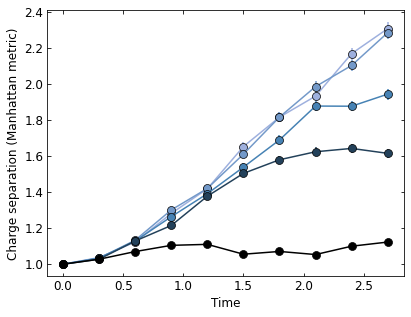

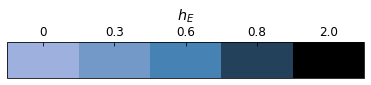

In [30]:
fig, ax = plt.subplots()

for idx, he in enumerate(he_list):
    ax.errorbar(x = np.arange(len(separations[he]))*dt, y = separations[he],yerr = separations_sdom[he],marker='o',color = blues_color_list[idx])

ax.set_xlabel('Time')
ax.set_ylabel('Charge separation (Manhattan metric)')

plt.show()

fig,ax = plt.subplots()
ax.set_aspect(0.1)

bounds = [-0.05]+[np.mean(he_list[i:i+2]) for i in range(len(he_list)-1)]+[1.7]
norm = matplotlib.colors.BoundaryNorm(bounds, blues_cmap_r.N)

matplotlib.colorbar.ColorbarBase(
    ax, cmap=blues_cmap_r, norm=norm, orientation='horizontal'
)

ax.set_xticks([np.mean(bounds[i:i+2]) for i in range(len(bounds)-1)],he_list)
ax.set_xticks([],minor=True)
ax.tick_params(top=True,bottom=False,labeltop=True,labelbottom=False)
ax.set_title(r'$h_E$')
plt.show()

### String Fluctations

Next we want to focus on the string of gauge flux connecting the charges. We can initialize that string by choosing the X-string we use to excite on top of the WALA state. In the present case, we excite `[cirq.GridQubit(-2,1), cirq.GridQubit(0,1), cirq.GridQubit(1,2), cirq.GridQubit(2,3), cirq.GridQubit(3,2), cirq.GridQubit(4,1), cirq.GridQubit(6,1)]`, which stretches across the entire grid as show in the schematic:

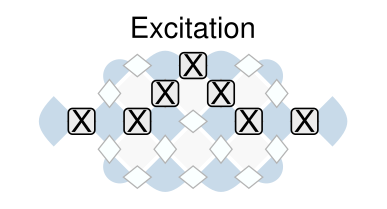

This excitation initializes two charges on the extra charge sites to the left and right, connected to the rest of the system by two additional qubits. By not applying the local field terms ($h_E Z_l$ and $\lambda X_l$) to these qubits, we can keep the charges on their initial sites and monitor the behavior of the string with pinned ends.

We will monitor the string dynamics by measuring the two-point correlator $\mathcal{S}_{ZZ}(t)$ defined as:

$$\mathcal{S}_{ZZ}(t)=\Re[\langle Z(t) Z(0) \rangle] \times \langle Z(0) \rangle.$$

Inspired by the implementation of these circuits on the quantum hardware, we utilize an auxiliary qubit to measure the two-time correlator $\Re[\langle Z(t) Z(0) \rangle]$ for each qubit. Then we measure $\langle Z(0) \rangle$ to get the second term in the product. Let's make the list of circuits to simulate:

In [31]:
he_list = [0.1,0.6,1.4]
dt = 0.3
coupling = 0.25
trotter_steps = [0,2,4,9]
auxillary_qubit = cirq.NamedQubit('a')
string_excitation_indices = [(-2,1),(0,1),(1,2),(2,3),(3,2),(4,1),(6,1)]
string_excitation_qubits = [cirq.GridQubit(idx1,idx2) for idx1,idx2 in string_excitation_indices]

time_evolution_circuits = []

for target_qubit in grid.physical_qubits:
    for he in he_list:
        for step in trotter_steps:
            time_evolution_circuits.append(cirq.Circuit.from_moments(
                cirq.H.on(auxillary_qubit),
                *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
                cirq.Moment(cirq.X.on_each(string_excitation_qubits)),
                cirq.CZ(auxillary_qubit,target_qubit),
                *lgt.trotter_step_minimal_qubits(grid,dt,coupling,he,extra_z_plaquette_indices=[(0,1),(3,1)])*step,
                cirq.H.on(auxillary_qubit),
                cirq.Moment(cirq.measure(auxillary_qubit,target_qubit, key="measure_all"))
            ))

initial_state_circuits = []

for he in he_list:
    initial_state_circuits.append(cirq.Circuit.from_moments(
        *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
        cirq.Moment(cirq.X.on_each(string_excitation_qubits)),
        cirq.Moment(cirq.measure(*sorted(grid.physical_qubits), key="measure_all"))
    ))

We have now expanded to 20 qubits and our observable requires the dynamics to be run separately for every gauge qubit. This means the simulations are a bit more expensive and may take up to one minute. Enjoy a short break while qsim does its work!

In [32]:
results_string_dynamics = simulator.run_batch(time_evolution_circuits,repetitions=reps)
results_string_initial = simulator.run_batch(initial_state_circuits,repetitions=reps)

We can now take those bitstrings and assemble $\mathcal{S}_{ZZ}$.

In [33]:
zz = {}

counter = 0
for idx,target_qubit in enumerate(grid.physical_qubits):
    for he in he_list:
        for step in trotter_steps:
            if idx == 0:
                zz[(he,step)] = []
            bitstrings = results_string_dynamics[counter][0].measurements['measure_all']
            zz[(he,step)].append(np.mean(np.sum(bitstrings,axis=1)%2))
            counter+=1

z0 = {}
z0_sdom = {}

for idx,he in enumerate(he_list):
    bitstrings = results_string_initial[idx][0].measurements['measure_all']
    z0[he] = np.mean(bitstrings,axis=0)
    z0_sdom[he] = np.std(bitstrings,axis=0)/np.sqrt(np.shape(bitstrings)[0])

Using these measurements, let's calculate $\mathcal{S}_{ZZ}(t)$ and plot it as heatmaps:

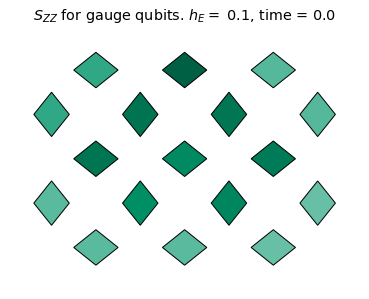

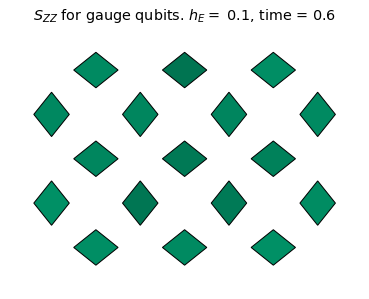

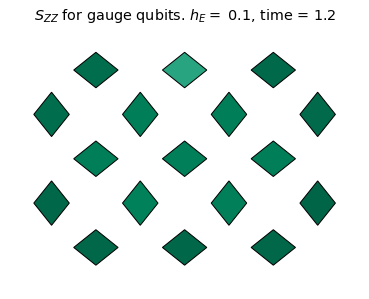

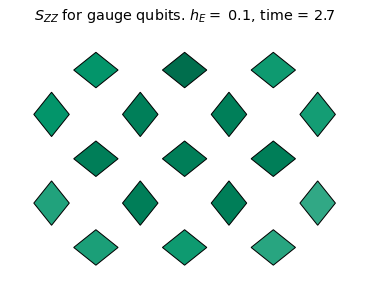

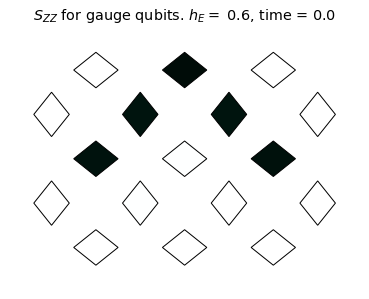

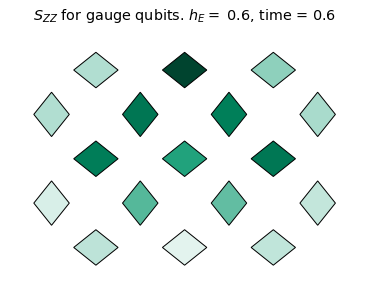

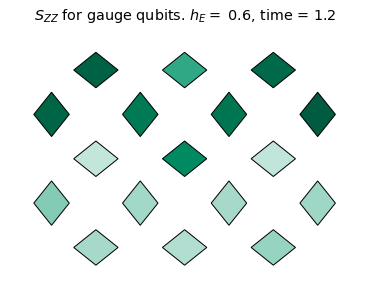

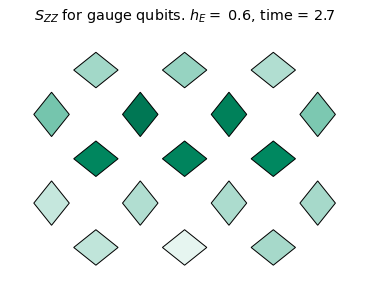

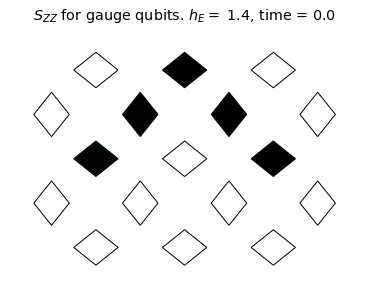

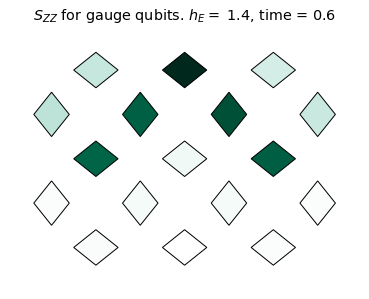

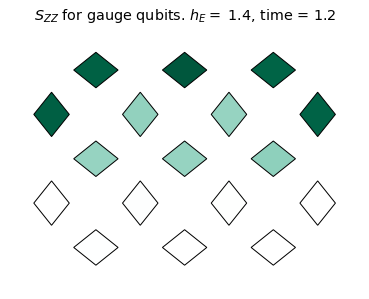

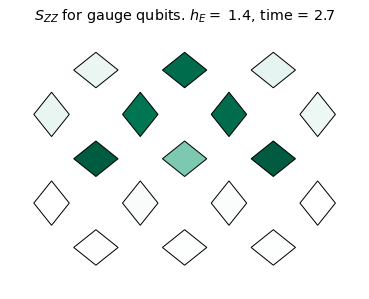

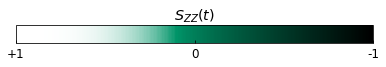

In [34]:
szz = {}

map = np.array([5,10,15,2,7,12,17,4,9,14,1,6,11,16,3,8,13,])-1

for he in he_list:
    for step in trotter_steps:
        szz[(he,step)] = bitstring_to_expectation_value(np.array(zz[(he,step)]))*bitstring_to_expectation_value(np.array(z0[he]))
        lgt.plot_qubit_polarization_values(
            grid = LGTGrid(origin_qubit = cirq.GridQubit(0,0),orientation_vector = (1,1), rows = grid.cols, cols = grid.rows, flip_rowcol = False),
            qubit_polarization_data=[szz[(he,step)][i] for i in map],
            ancilla_states_data=np.zeros(18),
            plot_physical_qubits=True,
            plot_ancillas = False,
            qubit_colormap=cmap_green
        )

        title_text = r'$S_{ZZ}$ for gauge qubits. '+  f'$h_E =$ {he}, time = {np.around(dt * step,3)}'

        plt.title(title_text)
        plt.ylim(grid.cols, -1)

        plt.show()

f,ax = plt.subplots()
ax.set_aspect(0.1)

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

matplotlib.colorbar.ColorbarBase(
    ax, cmap=cmap_green, norm=norm, orientation='horizontal'
)

ax.set_xticks([-1,0,1],labels=['+1','0','-1'])
ax.set_xticks([],minor=True)
ax.tick_params(right=False,labelright=False)
ax.set_title(r'$S_{ZZ}(t)$')

plt.show()

We see the coherent dynamics of the string in the confined phase ($h_E = 1.4$). In this case, the string mainly stays on the top qubits where it can undergo "breathing" type quantum vibrations without changing it's length on the lattice. However, in a more weakly confined regime ($h_E = 0.6$), the string evidently explores more modes of oscillation and is able to "flop" down to the bottom qubits. For $h_E=0.1$, there is no clear string excitation, even at the initial time. This is consistent with the deconfined phase.

To clearly quantitatively see these behaviors, we simulate a denser time sampling for just the top (Q1) and bottom (Q2) qubits in the center, as indicated below.

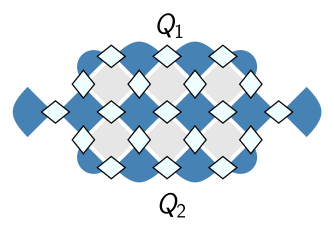

So let's construct the circuit as before but with more time steps and only simulate $\mathcal{S}_{ZZ}(t)$ for these two qubits.

In [35]:
he_list = [0.1,0.6,1.4]
trotter_steps = np.arange(10)
target_list = [grid.physical_qubits[9],grid.physical_qubits[7]]

time_evolution_circuits = []

for target_qubit in target_list:
    for he in he_list:
        for step in trotter_steps:
            time_evolution_circuits.append(cirq.Circuit.from_moments(
                cirq.H.on(auxillary_qubit),
                *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
                cirq.Moment(cirq.X.on_each(string_excitation_qubits)),
                cirq.CZ(auxillary_qubit,target_qubit),
                *lgt.trotter_step_minimal_qubits(grid,dt,coupling,he,extra_z_plaquette_indices=[(0,1),(3,1)])*step,
                cirq.H.on(auxillary_qubit),
                cirq.Moment(cirq.measure(auxillary_qubit,target_qubit, key="measure_all"))
            ))

Now let's simulate it and calculate $\mathcal{S}_{ZZ}(t)$! (This should take <1 minute)

In [36]:
results_string_dynamics = simulator.run_batch(time_evolution_circuits,repetitions=reps)

zz_fine = {}
zz_fine_sdom = {}

for target in target_list:
        for he in he_list:
             zz_fine[(target,he)] = []
             zz_fine_sdom[(target,he)] = []

counter = 0
for idx, target in enumerate(target_list):
    for he in he_list:
        for step in trotter_steps:
            bitstrings = results_string_dynamics[counter][0].measurements['measure_all']
            zz_fine[(target,he)].append(np.mean(np.sum(bitstrings,axis=1)%2))
            zz_fine_sdom[(target,he)].append(np.std(np.sum(bitstrings,axis=1)%2)/np.sqrt(np.shape(bitstrings)[0]))
            counter+=1

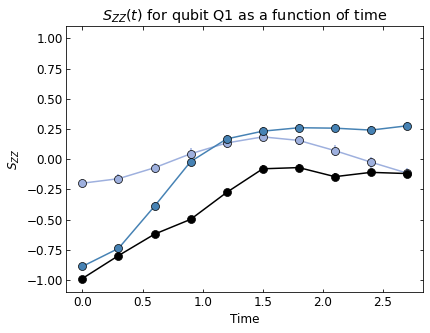

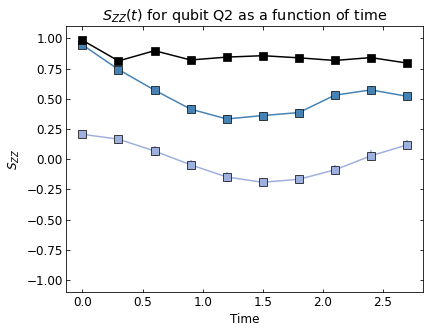

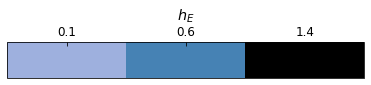

In [37]:
markers = ['o','s']

for idx2, target in enumerate(target_list):
    fig, ax = plt.subplots()

    for idx,he in enumerate(he_list):
        res = bitstring_to_expectation_value(np.array(zz_fine[(target,he)])) * bitstring_to_expectation_value(z0[he][grid.physical_qubits.index(target)])
        ax.errorbar(x = np.arange(len(res))*dt,y = res, yerr = 2*np.sqrt(np.array(zz_fine_sdom[(target,he)])**2 + np.array(z0_sdom[he][9])**2),color = blues_color_list[2*idx],marker = markers[idx2])

    ax.set_xlabel("Time")
    ax.set_ylabel(r"$S_{ZZ}$")
    ax.set_title(r"$S_{ZZ}(t)$ "+f"for qubit Q{idx2+1} as a function of time")
    ax.set_ylim(-1.1,1.1)

    plt.show()

fig,ax = plt.subplots()
ax.set_aspect(0.1)

bounds = [-0.05]+[np.mean(he_list[i:i+2]) for i in range(len(he_list)-1)]+[1.7]
norm = matplotlib.colors.BoundaryNorm(bounds, blues_cmap_r.N)

matplotlib.colorbar.ColorbarBase(
    ax, cmap=blues_cmap_r, norm=norm, orientation='horizontal'
)

ax.set_xticks([np.mean(bounds[i:i+2]) for i in range(len(bounds)-1)],he_list)
ax.set_xticks([],minor=True)
ax.tick_params(top=True,bottom=False,labeltop=True,labelbottom=False)
ax.set_title(r'$h_E$')
plt.show()

### String Breaking

Lastly, we want to examine the effects of string breaking by looking at the pair creation of charges that occur when the string breaks. To pinpoint the effects of the string on pair creation, we choose the most confining scenario ($h_E = 1.4$) and compare the dynamics of evolving two initials states: (1) just the WALA initial state and (2) the WALA state with the same string excitation that we used to study the string dynamics above. By comparing the effect that $\lambda$, the string breaking parameter, has in these two experiments, we can identify the interplay between string-breaking and pair creation.

Let's define the circuits for both initial states:

In [38]:
he = 1.4
coupling_list = [0,0.25,0.5]
dt = 0.3
trotter_steps = np.arange(10)
string_excitation_indices = [(-2,1),(0,1),(1,2),(2,3),(3,2),(4,1),(6,1)]
string_excitation_qubits = [cirq.GridQubit(idx1,idx2) for idx1,idx2 in string_excitation_indices]

excited_evolution_circuits = []

for coupling in coupling_list:
    for step in trotter_steps:
        excited_evolution_circuits.append(cirq.Circuit.from_moments(
            *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
            cirq.Moment(cirq.X.on_each(string_excitation_qubits)),
            *lgt.trotter_step_minimal_qubits(grid,dt,coupling,he,extra_z_plaquette_indices=[(0,1),(3,1)])*step,
            cirq.Moment(cirq.measure(grid.physical_qubits, key="measure_all"))
        ))

wala_evolution_circuits = []

for coupling in coupling_list:
    for step in trotter_steps:
        wala_evolution_circuits.append(cirq.Circuit.from_moments(
                *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
                *lgt.trotter_step_minimal_qubits(grid,dt,coupling,he,extra_z_plaquette_indices=[(0,1),(3,1)])*step,
                cirq.Moment(cirq.measure(grid.physical_qubits, key="measure_all"))
        ))

And simulate the results:

In [39]:
results_excited_evolution = simulator.run_batch(excited_evolution_circuits,repetitions=reps)
results_wala_evolution = simulator.run_batch(wala_evolution_circuits,repetitions=reps)

Now we can calculate the probability that a charge is pair-created at each site as these two initial states evolve in time:

In [40]:
counter = 0

trotter_steps = np.arange(10)

occupations_excited = {}

for coupling in coupling_list:
    for step in trotter_steps:
        res_excited = results_excited_evolution[counter][0].measurements['measure_all']
        occupations_excited[(coupling,step)] = lgt.plaquette_bitstrings(res_excited,grid,particle_locs=[(0,1),(3,1)])


        counter += 1

counter = 0

occupations_wala = {}

for coupling in coupling_list:
    for step in trotter_steps:
        res_wala = results_wala_evolution[counter][0].measurements['measure_all']
        occupations_wala[(coupling,step)] = lgt.plaquette_bitstrings(res_wala,grid)

        counter += 1

By substracting the expectation value of $A_v$ of the two initials states, we can directly see the effects of the string, which is mostly located on the top qubits. The results, plotted below, show that charges are pair-created when $\lambda \neq 0$, but predominantly on the middle and top rows of charge sites where the string is located, with enhanced pair creation as $\lambda$ increases.

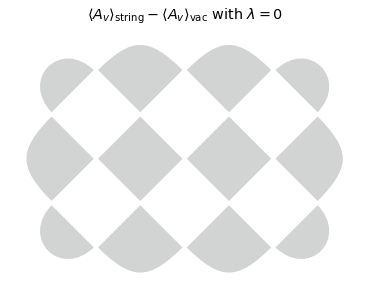

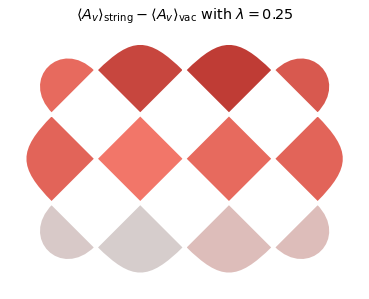

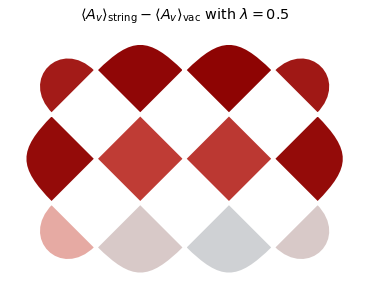

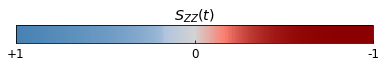

In [41]:
code = tcr.ToricCodeRectangle(origin_qubit=cirq.GridQubit(0,0), row_vector=(1,1), rows=grid.cols, cols=grid.rows)

for coupling in coupling_list:
    tc_plot.ToricCodePlotter(z_cmap = diff_cmap, x_cmap = matplotlib.colormaps['binary']).plot_expectation_values(tc_plaq.ToricCodePlaquettes(
        code,
        x_plaquettes = np.zeros((2,3))-1,
        z_plaquettes = {(grid.cols - p%(grid.cols+1),p//(grid.cols + 1)):bitstring_to_expectation_value(np.mean(occupations_excited[(coupling,9)],axis=0)[p])-bitstring_to_expectation_value(np.mean(occupations_wala[(coupling,9)],axis=0)[p]) for p in range((grid.rows+1)*(grid.cols+1))}
    ))
    
    title_text = r'$\langle A_v \rangle_{\mathrm{string}} - \langle A_v \rangle_{\mathrm{vac}} $ with $\lambda = $' + f"{coupling}"

    plt.title(title_text)

    plt.show()

f,ax = plt.subplots()
ax.set_aspect(0.1)

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

matplotlib.colorbar.ColorbarBase(
    ax, cmap=diff_cmap_r, norm=norm, orientation='horizontal'
)

ax.set_xticks([-1,0,1],labels=['+1','0','-1'])
ax.set_xticks([],minor=True)
ax.tick_params(right=False,labelright=False)
ax.set_title(r'$S_{ZZ}(t)$')

plt.show()

To show this quantitatively, we plot the probability of observing a charge as a function of time when $\lambda \in \{0,0.25,0.5\}$ for three different charge sites:

(1) $A_{\mathrm{vac}}$ on the top/bottom of WALA initial state (black)

(2) $A_1$ on the top of the initial state with a string excitation (yellow)

(3) $A_3$ on the bottom of the initial state with the string excitation (mint)

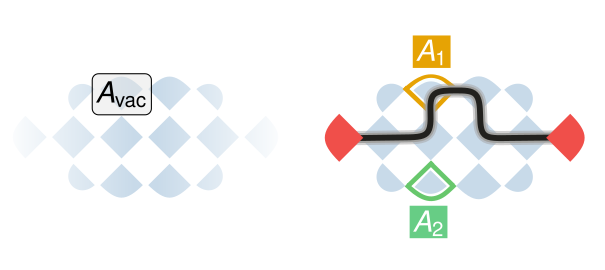

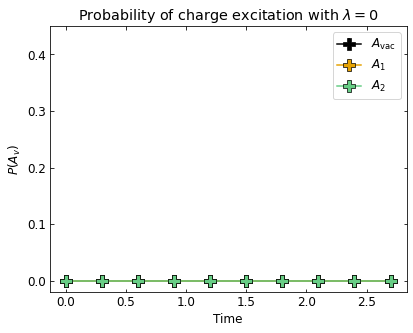

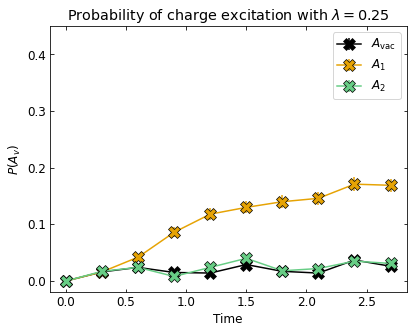

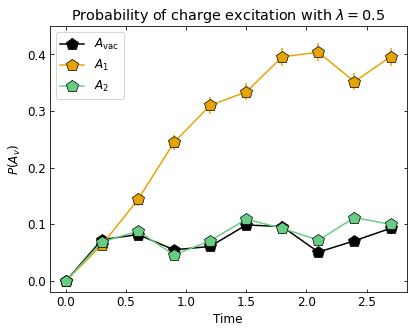

In [42]:
coupling = 0
marker_dict = {0:'P',0.25:'X',0.5:'p'}


for coupling in coupling_list:

    fig, ax = plt.subplots()

    mark = marker_dict[coupling]
    ms = 12

    res = [np.mean(occupations_wala[(coupling,p)],axis=0)[5] for p in range(len(trotter_steps))]
    sdom = [np.std(occupations_wala[(coupling,p)],axis=0)[5]/np.sqrt(np.shape(occupations_wala[(coupling,p)])[0]) for p in range(len(trotter_steps))]
    ax.errorbar(x = np.arange(len(res))* dt, y = res,yerr = sdom, color = BREAKING_VAC, marker = mark, markersize = ms, label = "$A_{\mathrm{vac}}$")
    
    res = [np.mean(occupations_excited[(coupling,p)],axis=0)[5] for p in range(len(trotter_steps))]
    sdom = [np.std(occupations_excited[(coupling,p)],axis=0)[5]/np.sqrt(np.shape(occupations_excited[(coupling,p)])[0]) for p in range(len(trotter_steps))]
    ax.errorbar(x = np.arange(len(res))* dt, y = res,yerr = sdom, color = BREAKING_TOP, marker = mark, markersize = ms, label = "$A_1$")
    
    res = [np.mean(occupations_excited[(coupling,p)],axis=0)[3] for p in range(len(trotter_steps))]
    sdom = [np.std(occupations_excited[(coupling,p)],axis=0)[3]/np.sqrt(np.shape(occupations_excited[(coupling,p)])[0]) for p in range(len(trotter_steps))]
    ax.errorbar(x = np.arange(len(res))* dt, y = res,yerr = sdom, color = BREAKING_BOTTOM, marker = mark, markersize = ms, label = "$A_2$")

    

    

    ax.set_xlabel('Time')
    ax.set_ylabel(r'$P(A_v)$')
    ax.set_title(f'Probability of charge excitation with $\lambda = {coupling}$')

    ax.set_ylim(-0.02,0.45)

    ax.legend()

    plt.show()

Finally, we want to explore the dependence on the confinement parameter, $h_E$. We naively expect a resonance in pair creation near $h_E = 2,$ when the energy "cost" of creating two charges is equal to the energy "gained" by shorting the gauge string by one link. We will compare the probability of finding a charge on site $A_1$ at time $t=2$, once the probability of pair creation has saturated.

Let's define the circuits:

In [43]:
he_list = np.around(np.arange(1,3.1,0.4),2)
coupling_list = [0,0.25,0.5]
dt = 0.2
trotter_steps = [10]
string_excitation_indices = [(-2,1),(0,1),(1,2),(2,3),(3,2),(4,1),(6,1)]
string_excitation_qubits = [cirq.GridQubit(idx1,idx2) for idx1,idx2 in string_excitation_indices]

resonance_circuits = []

for coupling in coupling_list:
    for he in he_list:
        for step in trotter_steps:
            resonance_circuits.append(cirq.Circuit.from_moments(
                *lgt.variational_ground_state_minimal_qubits(grid,angles[he]),
                cirq.Moment(cirq.X.on_each(string_excitation_qubits)),
                *lgt.trotter_step_minimal_qubits(grid,dt,coupling,he,extra_z_plaquette_indices=[(0,1),(3,1)])*step,
                cirq.Moment(cirq.measure(grid.physical_qubits, key="measure_all"))
            ))

and simulate them:

In [44]:
results_resonance = simulator.run_batch(resonance_circuits,repetitions=reps)

counter = 0

occupations_resonance = {}
occupations_resonance_sdom = {}

for coupling in coupling_list:
    for he in he_list:
        for step in trotter_steps:
            res = results_resonance[counter][0].measurements['measure_all']
            occupations_resonance[(coupling,he,step)] = lgt.plaquette_bitstrings(res,grid,particle_locs=[(0,1),(3,1)])

            counter += 1

Now when looking at the plotted results, we see that indeed there is a resonance-like feature near $h_E = 2$.

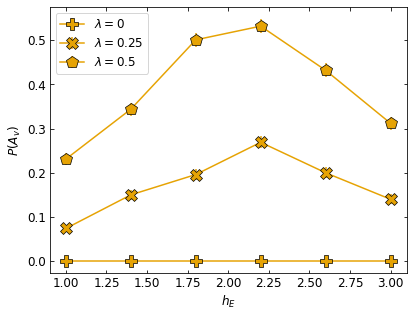

In [45]:
marker_dict = {0:'P',0.25:'X',0.5:'p'}

fig, ax = plt.subplots()

for coupling in coupling_list:
    res = [np.mean(occupations_resonance[(coupling,he,10)],axis=0)[5] for he in he_list]
    sdom = [np.std(occupations_resonance[(coupling,he,10)],axis=0)[5]/np.sqrt(np.shape(occupations_resonance[(coupling,he,10)])[0]) for he in he_list]
    ax.errorbar(x = he_list, y = res, yerr = sdom, markersize = 12, color = '#e6a304ff',marker = marker_dict[coupling], label = f"$\lambda = {coupling}$")

ax.set_xlabel(r'$h_E$')
ax.set_ylabel(r'$P(A_v)$')
ax.legend()

plt.show()

Congratulations, you've made it to the end of this tutorial! To explore the details of the formulation of this experiment and the results from the quantum processor, please refer to the [paper and its supplement](https://arxiv.org/abs/2409.17142).